# Data Analyis of Canva Data
Here, we will be clearning, transforming and modelling the canva data.

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, HTML
import pycountry
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import gaussian_kde
import statsmodels.api as sm


canva_templates_df = pd.read_csv("./data/canva_templates.csv")
canva_templates_df.head()


,locale_code,bespoke_i18n,creator_en,creator_i18n,en,localized_child
0,af-ZA,2,0,3,0,0
1,ar,1760,0,31877,0,16195
2,ar-AE,2196,0,942,0,260
3,ar-EG,1404,0,17986,0,8528
4,ar-SA,1050,0,18708,0,167


## Stage 1: Cleaning
### 1. MAUs: Duplicate Average, Removing Unkowns
We have noticed several duplicate rows in the MAU dataset with differing MAU numbers. Since we cannot assume which entry is correct, and it also doesnt seem to be the result of seperate observations that require aggregation, we will simply average entries with duplicate Month + Plan Type + Country Code.

In [34]:
mau_df = pd.read_csv("./data/mau_by_plan_type.csv")
population_df = pd.read_csv("./data/global_population.csv")

def code_to_name(code):
    try:
        return pycountry.countries.lookup(code).name
    except:
        return None

# rename columns to lowercase for consistency
mau_df.rename(columns={'MONTH_END_DATE': "month_end_date", 'PRIMARY_PLAN_TYPE': 'primary_plan_type', 'COUNTRY_CODE': 'country_code',
                       'Monthly Active Users': 'monthly_active_users'}, inplace=True)

# group similar rows together
mau_df = (
    mau_df
      .groupby(['month_end_date', 'primary_plan_type', 'country_code'], as_index=False)
      ['monthly_active_users']
      .mean()
)

# typecast as int
mau_df['monthly_active_users'] = np.ceil(mau_df['monthly_active_users']).astype(int)

# convert code to country name
mau_df['country_code'] = mau_df['country_code'].apply(code_to_name)

# rename country_code to country for consistency between tables (for joining later)
mau_df.rename(columns={'country_code': 'country', 'monthly_active_users': 'mau'}, inplace=True)

# cleaning global population data
population_df.rename(columns={'Country Name': 'country', '2024': 'total_population'}, inplace=True)
population_df["total_population"] = population_df["total_population"].astype('Int64')

# reset indexes
mau_df = mau_df[mau_df["primary_plan_type"] != "Unknown"].reset_index(drop=True).sort_values(by = ['country', 'month_end_date', 'primary_plan_type'])
mau_df.head(10)

,month_end_date,primary_plan_type,country,mau
2,2020-01-31,Canva Pro,Afghanistan,5
89,2020-01-31,Canva Pro - NFP,Afghanistan,2
245,2020-01-31,Education,Afghanistan,3
428,2020-02-29,Canva Pro,Afghanistan,6
529,2020-02-29,Canva Pro - NFP,Afghanistan,1
615,2020-02-29,Canva for Teams,Afghanistan,1
692,2020-02-29,Education,Afghanistan,5
995,2020-03-31,Canva Pro - NFP,Afghanistan,1
1150,2020-03-31,Education,Afghanistan,4
2060,2020-05-31,Domain,Afghanistan,1


### 2. Device Tiers: Matching Table Headers
We notice that in the Device Tiers table, countries are referred to by name rather than code. To preserve consistency, we will convert names to code.

In [35]:
device_tiers_df = pd.read_csv("./data/device_tiers.csv")


def name_to_code(name):
    try:
        return pycountry.countries.lookup(name).alpha_2
    except:
        return None


device_tiers_df = device_tiers_df.reset_index(drop=True).sort_values(by="Country")
device_tiers_df[['High', 'Mid', 'Low', 'Unknown']] = device_tiers_df[['High', 'Mid', 'Low', 'Unknown']].astype('Int64')
device_tiers_df.head()

# renaming headings to match other dataframes
device_tiers_df.rename(columns={'Country': 'country', 'High': 'high_device_tier', 'Mid': 'mid_device_tier', 
                                'Low': 'low_device_tier', 'Unknown': 'unknown_device_tier', 'Total': 'total_mau'}, inplace=True)

# cleaning global population data
population_df.rename(columns={'Country Name': 'country', '2024': 'total_population'}, inplace=True)
population_df["total_population"] = population_df["total_population"].astype('Int64')

# joining global population data to device tiers data
device_tiers_df = device_tiers_df.merge(population_df[['country', 'total_population']], on='country', how='left')
device_tiers_df.head()


,country,high_device_tier,mid_device_tier,low_device_tier,unknown_device_tier,total_mau,total_population
0,Afghanistan,6491,6277,1948,554,15270,42647492
1,Albania,23814,3914,432,1958,30118,2714617
2,Algeria,85198,76059,29307,6684,197248,46814308
3,American Samoa,407,115,9,94,625,46765
4,Andorra,3565,694,33,588,4880,81938


## Stage 2: Data Transformation/Analysis: Global
We will analyse the data on a global scale to identify trends and patterns.

### 1. Total Usage Density Heatmap
We will create a Density Heatmap to visualise the proportion of active users in each country.



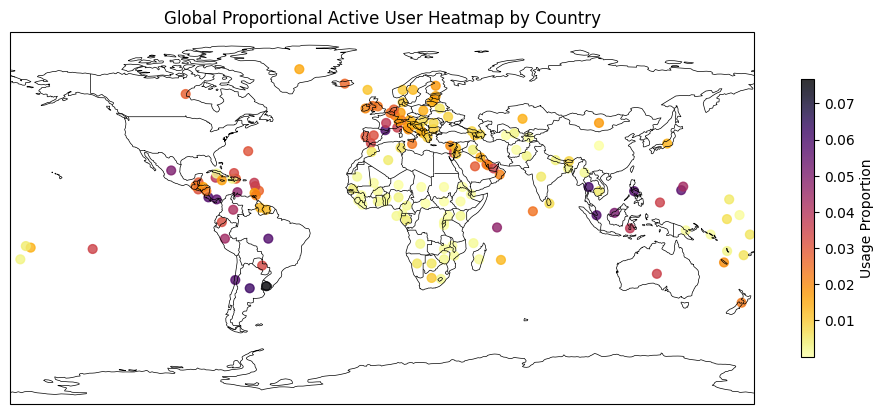

In [36]:
# reading in country coordinates data and cleaning it
country_coords_df = pd.read_csv("./data/country_coords.csv")
country_coords_df.rename(columns={'Country': 'country', 'Latitude (average)': 'latitude', 'Longitude (average)': 'longitude'}, inplace=True)
country_coords_df.drop(columns=['Alpha-2 code', 'Alpha-3 code', 'Numeric code'], inplace=True)
country_coords_df.head()

# merging device tiers data with country coordinates data and calculating usage proportion into a new dataframe
location_usage_df = device_tiers_df[['country', 'total_mau', 'total_population']].merge(country_coords_df, on='country', how='left')
location_usage_df.insert(3, 'usage_proportion', location_usage_df['total_mau'] / location_usage_df['total_population'])
location_usage_df.head()

### visualizing location usage data on a 2d heatmap
# create figure and axis with global projection
heatmap = plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.PlateCarree())

# add world boundaries and coastlines
axes.add_feature(cfeature.BORDERS, linewidth=0.5)
axes.add_feature(cfeature.COASTLINE, linewidth=0.5)
axes.set_global()

# scatter plot with usage proportion as heat intensity
scatter_plot = axes.scatter(
    location_usage_df['longitude'],
    location_usage_df['latitude'],
    c=location_usage_df['usage_proportion'],
    cmap='inferno_r',
    s=40,
    alpha=0.8,
    transform=ccrs.PlateCarree()
)

# add colorbar
cbar = plt.colorbar(scatter_plot, ax=axes, orientation='vertical', shrink=0.6, pad=0.05)
cbar.set_label('Usage Proportion')

plt.title('Global Proportional Active User Heatmap by Country')
plt.show()

## 2. Predictive Linear Regression Model
We will build a linear regression model to predict future MAU based on the following predictors:
- Median Age
- Internet Penetration Rate
- GDP per Capita
- Bachelor's Degree or Higher Percentage

## 

In [ ]:
## reading in predictor datasets ------------------------------------
bachelors_attainment_df = pd.read_csv("./data/bachelors_attainment.csv")
median_age_df = pd.read_csv("./data/median_age.csv")
gdp_per_capita_df = pd.read_csv("./data/gdp_per_capita.csv")
internet_penetration_df = pd.read_csv("./data/internet_penetration.csv")


bachelors_melted = bachelors_attainment_df.melt(
    id_vars=['Country Name', 'Country Code'],
    var_name='Year',
    value_name='Value'
)

## cleaning data ----------------------------------------
# cleaning bachelor's attainment data
bachelors_melted['Year'] = pd.to_numeric(bachelors_melted['Year'], errors='coerce')
bachelors_melted['Year'] = bachelors_melted['Year'].astype('Int64')
bachelors_melted = bachelors_melted.dropna(subset=['Value'])
bachelors_melted = bachelors_melted.sort_values(['Country Code', 'Year'])
bachelors_melted = bachelors_melted.groupby('Country Code').tail(1).reset_index(drop=True)
bachelors_melted['Value'] = bachelors_melted['Value'].round(2)
bachelors_attainment_df = bachelors_melted.rename(columns={
    'Country Name': 'country',
    'Country Code': 'country_code',
    'Year': 'year',
    'Value': 'bachelors_attainment_percentage'
})
bachelors_attainment_df.head()

# cleaning gdp per capita data
gdp_melted = gdp_per_capita_df.melt(
    id_vars=['Country Name', 'Country Code'],
    var_name='Year',
    value_name='Value'
)

gdp_melted['Year'] = pd.to_numeric(gdp_melted['Year'], errors='coerce')
gdp_melted['Year'] = gdp_melted['Year'].astype('Int64')
gdp_melted = gdp_melted.dropna(subset=['Value'])
gdp_melted = gdp_melted.sort_values(['Country Code', 'Year']).groupby('Country Code').tail(1).reset_index(drop=True)
gdp_melted['Value'] = gdp_melted['Value'].round(2)
gdp_per_capita_df = gdp_melted.rename(columns={
    'Country Name': 'country',
    'Country Code': 'country_code',
    'Year': 'year',
    'Value': 'gdp_per_capita_usd'
})
gdp_per_capita_df.head()

# cleaning internet penetration data
internet_melted = internet_penetration_df.melt(
    id_vars=['Country Name', 'Country Code'],
    var_name='Year',
    value_name='Value'
)

internet_melted['Year'] = pd.to_numeric(internet_melted['Year'], errors='coerce')
internet_melted['Year'] = internet_melted['Year'].astype('Int64')
internet_melted = internet_melted.dropna(subset=['Value'])
internet_melted = internet_melted.sort_values(['Country Code', 'Year']).groupby('Country Code').tail(1).reset_index(drop=True)
internet_melted['Value'] = internet_melted['Value'].round(2)
internet_penetration_df = internet_melted.rename(columns={
    'Country Name': 'country',
    'Country Code': 'country_code',
    'Year': 'year',
    'Value': 'internet_penetration_percentage'
})
internet_penetration_df.head()

# cleaning median age data
median_age_df = median_age_df.rename(columns={
    'Entity': 'country', 
    'Code': 'country_code', 
    'Year': 'year', 
    'Median age - Sex: all - Age: all - Variant: estimates': 'median_age'
})
median_age_df = median_age_df.dropna(subset=['median_age'])
median_age_df = median_age_df.sort_values(['country_code', 'year']).groupby('country_code').tail(1).reset_index(drop=True)
median_age_df['median_age'] = median_age_df['median_age'].round(2)
median_age_df.head(30)


## join datasets together ----------------------------------------
predictor_df = bachelors_attainment_df[['country', 'country_code', 'bachelors_attainment_percentage']].merge(
    gdp_per_capita_df[['country_code', 'gdp_per_capita_usd']],
    on='country_code',
    how='left'
).merge(
    internet_penetration_df[['country_code', 'internet_penetration_percentage']],
    on='country_code',
    how='left'
).merge(
    median_age_df[['country_code', 'median_age']],
    on='country_code',
    how='left'
).merge(
    location_usage_df[['country', 'usage_proportion']],
    on='country',
    how='left'
)
predictor_df = predictor_df.dropna()
predictor_df.head(60)

# create linear regression model
predictors = predictor_df[['bachelors_attainment_percentage', 'gdp_per_capita_usd', 'internet_penetration_percentage', 'median_age']]
response = predictor_df['usage_proportion']
predictors = sm.add_constant(predictors)  # add constant term for intercept
model = sm.OLS(response, predictors).fit()
print(model.summary())




                            OLS Regression Results                            
Dep. Variable:       usage_proportion   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     18.78
Date:                Mon, 20 Oct 2025   Prob (F-statistic):           2.04e-10
Time:                        18:11:07   Log-Likelihood:                 441.61
No. Observations:                 156   AIC:                            -875.2
Df Residuals:                     152   BIC:                            -863.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     